# Neural ODE

In [2]:
import jax
import jax.numpy as jnp
import jax.random as jr
import optax
import equinox as eqx
import diffrax
import jax.nn as jnn
import matplotlib.pyplot as plt
import time
from datetime import datetime

In [3]:
def get_data(ts, y0):
    def f(t, y, args):
        beta, alpha = args
        S, I = y
        return jnp.array([-beta * S * I, beta * S * I - alpha * I])

    args = (0.025, 0.2)
    sol = diffrax.diffeqsolve(
        diffrax.ODETerm(f),
        diffrax.Tsit5(),
        t0=0,
        t1=ts[-1],
        dt0=0.1,
        y0=y0,
        args=args,
        saveat=diffrax.SaveAt(ts=ts)
    )
    return ts, sol.ys


def relative_error(pred, true):
    return jnp.linalg.norm(pred - true, 2) / jnp.linalg.norm(true, 2)

In [4]:
class Func(eqx.Module):
    alpha: eqx.nn.MLP
    beta: eqx.nn.MLP

    def __init__(self, width_size, depth, *, key):
        key1, key2 = jr.split(key, 2)
        self.alpha = eqx.nn.MLP(1, 1, width_size, depth, activation=jnn.softplus, final_activation=jnn.sigmoid, key=key1)
        self.beta = eqx.nn.MLP(1, 1, width_size, depth, activation=jnn.softplus, final_activation=jnn.sigmoid, key=key2)

    def __call__(self, t, y, args):
        S, I = y
        t_input = jnp.array([t])
        beta = self.beta(t_input)[0]
        alpha = self.alpha(t_input)[0]
        dSdt = -beta * S * I
        dIdt = beta * S * I - alpha * I
        return jnp.array([dSdt, dIdt])


class NeuralODE(eqx.Module):
    func: Func

    def __init__(self, width_size, depth, *, key):
        self.func = Func(width_size, depth, key=key)

    def __call__(self, ts, y0):
        solution = diffrax.diffeqsolve(
            diffrax.ODETerm(self.func),
            diffrax.Tsit5(),
            t0=0,
            t1=ts[-1],
            dt0=0.01,
            y0=y0,
            stepsize_controller=diffrax.PIDController(rtol=1e-3, atol=1e-6),
            saveat=diffrax.SaveAt(ts=ts)
        )
        return solution.ys


def main(
    lr=3e-3,
    width_size=64,
    depth=2,
    seed=5678,
    steps=1000,
):
    key = jr.PRNGKey(seed)

    ts = jnp.linspace(0., 30., 100)
    y0 = jnp.array([100.0, 1.0])
    ts, ys = get_data(ts, y0)

    model = NeuralODE(width_size, depth, key=key)
    optim = optax.adam(lr)

    @eqx.filter_value_and_grad
    def grad_loss(model):
        pred = model(ts, y0)
        return jnp.mean((pred - ys) ** 2)

    @eqx.filter_jit
    def make_step(model, opt_state):
        loss, grads = grad_loss(model)
        updates, opt_state = optim.update(grads, opt_state, value=loss)
        model = eqx.apply_updates(model, updates)
        return loss, model, opt_state

    opt_state = optim.init(eqx.filter(model, eqx.is_inexact_array))
    loss_list = []

    for step in range(steps):
        loss, model, opt_state = make_step(model, opt_state)
        loss_list.append(loss)
        if step % 100 == 0 or step == steps - 1:
            print(f"Step {step}, Loss: {loss:.4e}")

    return ts, ys, model, loss_list

In [5]:
data_ts, data_ys, model, loss_list = main()

Step 0, Loss: 5.5673e+02
Step 100, Loss: 3.3126e+02
Step 200, Loss: 3.1676e+02
Step 300, Loss: 3.1258e+02
Step 400, Loss: 3.1133e+02
Step 500, Loss: 3.1085e+02
Step 600, Loss: 3.1061e+02
Step 700, Loss: 3.1046e+02
Step 800, Loss: 3.1036e+02
Step 900, Loss: 3.1028e+02
Step 999, Loss: 3.1021e+02


In [6]:
data_ts.shape, data_ys.shape

((100,), (100, 2))

Text(0.5, 1.0, 'Training Loss')

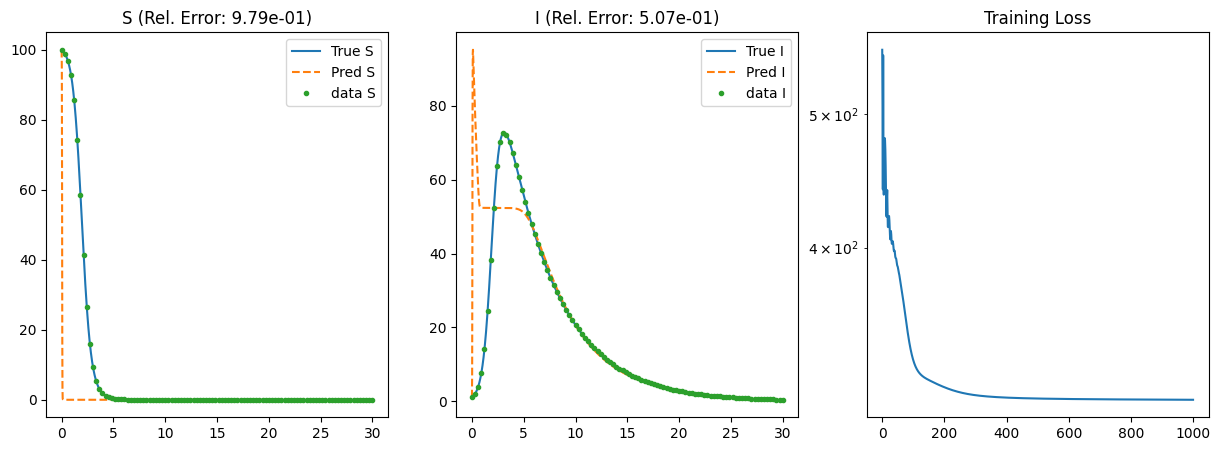

In [7]:
y0 = jnp.array([100.0, 1.0])
exact_ts, exact_ys = get_data(jnp.linspace(0, 20, 1000), y0)

model_ys = model(exact_ts, y0)

rel_S = relative_error(model_ys[:, 0], exact_ys[:, 0])
rel_I = relative_error(model_ys[:, 1], exact_ys[:, 1])

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].plot(exact_ts, exact_ys[:, 0], label="True S")
axs[0].plot(exact_ts, model_ys[:, 0], label="Pred S", linestyle="--")
axs[0].plot(data_ts, data_ys[:, 0], label="data S", linestyle="None", marker=".")
axs[0].set_title(f"S (Rel. Error: {rel_S:.2e})")
axs[0].legend()

axs[1].plot(exact_ts, exact_ys[:, 1], label="True I")
axs[1].plot(exact_ts, model_ys[:, 1], label="Pred I", linestyle="--")
axs[1].plot(data_ts, data_ys[:, 1], label="data I", linestyle="None", marker=".")
axs[1].set_title(f"I (Rel. Error: {rel_I:.2e})")
axs[1].legend()

axs[2].plot(loss_list)
axs[2].set_yscale("log")
axs[2].set_title("Training Loss")

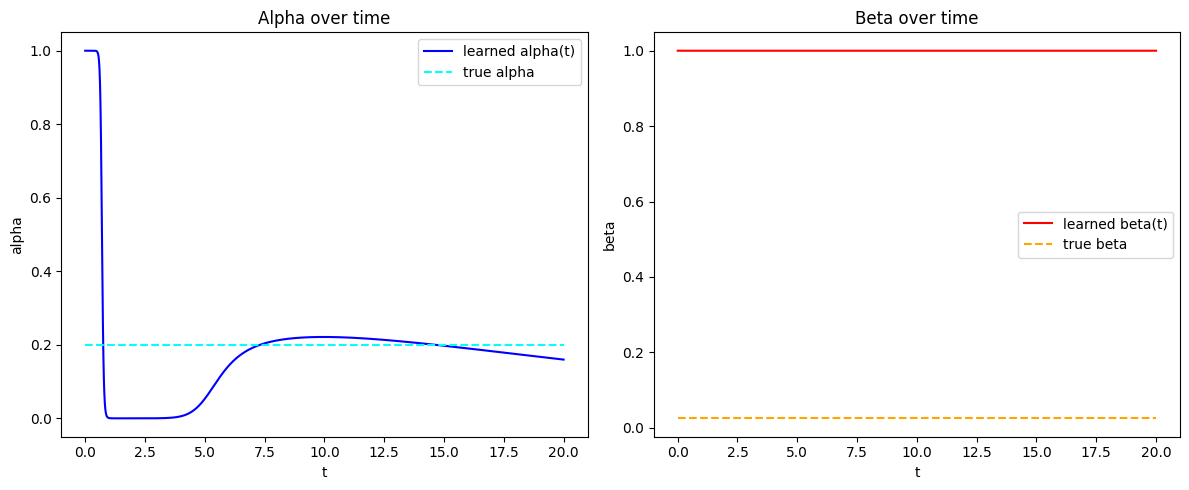

In [8]:
def get_alpha_beta(model, ts):
    t_inputs = ts[:, None]  # (N,) -> (N,1)
    alpha_raw = jax.vmap(model.func.alpha)(t_inputs)
    beta_raw = jax.vmap(model.func.beta)(t_inputs)
    alpha = alpha_raw[:, 0]
    beta = beta_raw[:, 0]
    return alpha, beta

ts_plot = jnp.linspace(0, 20, 1000)

alpha_vals, beta_vals = get_alpha_beta(model, ts_plot)

alpha_true = 0.2 * jnp.ones_like(ts_plot)
beta_true = 0.025 * jnp.ones_like(ts_plot)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(ts_plot, alpha_vals, label='learned alpha(t)', color='blue')
plt.plot(ts_plot, alpha_true, label='true alpha', linestyle='dashed', color='cyan')
plt.title('Alpha over time')
plt.xlabel('t')
plt.ylabel('alpha')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(ts_plot, beta_vals, label='learned beta(t)', color='red')
plt.plot(ts_plot, beta_true, label='true beta', linestyle='dashed', color='orange')
plt.title('Beta over time')
plt.xlabel('t')
plt.ylabel('beta')
plt.legend()

plt.tight_layout()
plt.show()